
–

**Summary**

*Objective*. To compare the prediction result of ARIMA and LSTM on the total sum of web traffic from July 2nd, 2016 to December 31st, 2016.

*Study Design.* Data are downloaded from Kaggle and was used as competition before.

*Methods.* ARIMA and LSTM are used to forcasting the total no. of vistiors.

*Result.* ARIMA performed poorly on forcasting the web traffic numbers while LSTM performed really well.

–



## 1. Introduction


Web Traffic Analysis is always a hot topic for better understanding current customers and it may provide some insights for the marketing team to structure their marketing strategy. The reviews of a web-pages will go up and down on different days. For example, weekdays and weekend may cause out a huge different on web-page reviews. Therefore, tackling the web traffic situation could help the business to build marketing strategies especially on the frequency of web-page update. 

The data set is downloaded from Kaggle (https://www.kaggle.com/c/web-traffic-time-series-forecasting/data) and this was a competition on time-series data forecasting. There are several data set which contained the daily reviews of different Wikipedia articles from July 1st, 2015 to March 1st, 2017. In this analysis report, the reviews record from July 1st, 2015 to December 31th, 2016 is used. The data from July 1st, 2015 to July 1st,2016 is used for model training and the web traffic records from July 2nd, 2016 to December 31st, 2016 is used as validation.

ARIMA and LSTM are the two prediction methods used in this analysis. AutoRegressive Integrated Moving Average(ARIMA) is the typical prediction method in time-series analysis, however, it may not perfom well in complex data. Long Short-Term Memory(LSTM) is a special form of Recurrent Neural Network(RNN) and this advancing prediction method is also applied in this analysis.

This analysis was running within Colab environment.

## 2. Initial Data Visualization

The original data set contained 551 columns and 145063 rows. The first column of the data contianed the name of the wikipedia page, the domain of the page, access types and agent details. The rest of columns are the no. of visits on each date. The first few rows is shown as below for reference. 

In [103]:
# import the data set and preview it
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
train1 = pd.read_csv("train_1.csv")
train1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [105]:
# simple data information
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


To generating the basic web traffic prediction, this analysis is focusing on total sum of visits on each date only and the missing values are excluded as the aim is to compare the performance of two different prediction methods. Further analysis and prediction on access types or domain details will be draw out as another analysis report later.

In [106]:
# sum all the no. of visits for each wikipedia page by date and exclude all the missing value
train1.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [107]:
# setup new dataframe which contain the total sum and date only
totalvisit=train1.isna().sum()[1:551]
date=train1.columns[1:551]
df = pd.DataFrame(list(zip(date,totalvisit)),columns=['Date','Visit'])

# set time series as the index
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df.set_index('Date', inplace = True)
df.head()

,Visit
Date,
2015-07-01,20740
2015-07-02,20816
2015-07-03,20544
2015-07-04,20654
2015-07-05,20659


After setting the date details as time-series index and exculding all the missing values, the summary of the new data set is shown as below. It is easy to figure out that the data set lasts for 550 days and average no. of visits between thw whole period was around 11260. At the same time, the range of total no. of visits on all wikipedia page was from 3189 to 20816.

In [ ]:
df.describe()

,Visit
count,550.000000
mean,11259.874545
std,5275.772841
min,3189.000000
25%,6614.500000
50%,10560.500000
75%,15792.500000
max,20816.000000


According to the image as below, it shows that the no. of visits is kept decreasing from 2015 to 2016. 

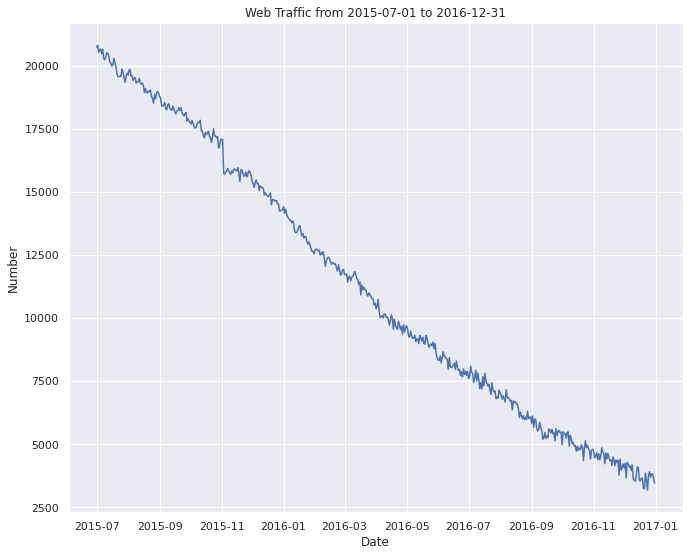

In [108]:
# plot the graph of data
plt.title('Web Traffic from 2015-07-01 to 2016-12-31')
plt.xlabel('Date')
plt.ylabel('Number')
plt.plot(df)
plt.show()


## 3. Prediction Method - ARIMA


AutoRegressive Integrated Moving Average(ARIMA) makes use of lagged moving averages to smooth time series data. Based on the definition in Investopedia,

*   Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
*   Integrated (I): represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
*   Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

To fulfill the assumption of applying ARIMA method, the data should be **stationary** and **seasonal**. If the data is stationary that the mean, variance and autocorrelation structure do not change over time. Differencing the time-series data is an easy way to modify the data set if it is not stationary.

###### *The definition is available at https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp*

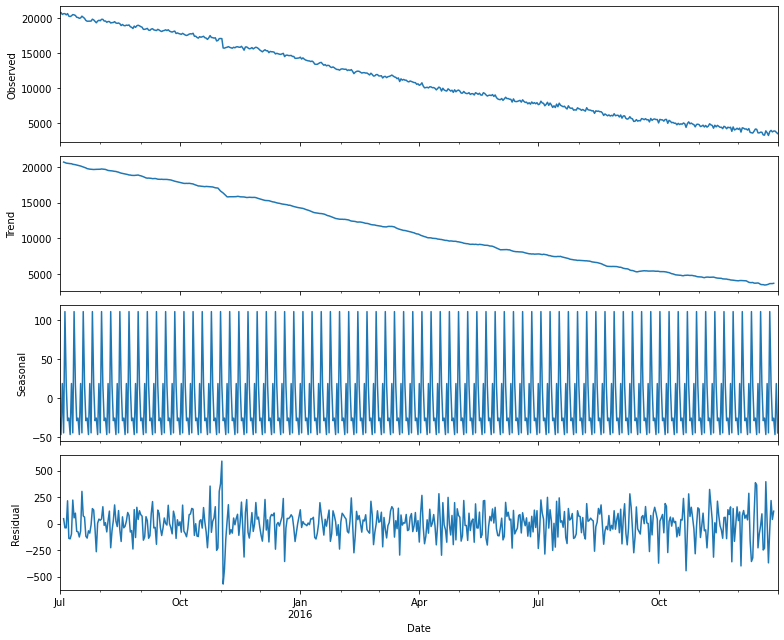

In [ ]:
# check whether the data is seasonal
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

According to the seasonal graph(3rd graph) as above, it is clear to find that the data is keeping as same trend. Therefore, the web traffic data is seasonal.

To confirm whether the data is stationary is the next step.

In [109]:
# setup the stationary functionn and check the stationary of the dataset
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(df['Visit'])

# the function was provided by https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.280250
p-value                          0.178417
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


From the test result as above, the data is not stationary as the test statistic is larger than all critical values. Then taking a **log transformation** to see whether the data could be stationary instead.

In [ ]:
df_log = np.log(df)
df_log.head()

,Visit
Date,
2015-07-01,9.939819
2015-07-02,9.943477
2015-07-03,9.930324
2015-07-04,9.935664
2015-07-05,9.935906


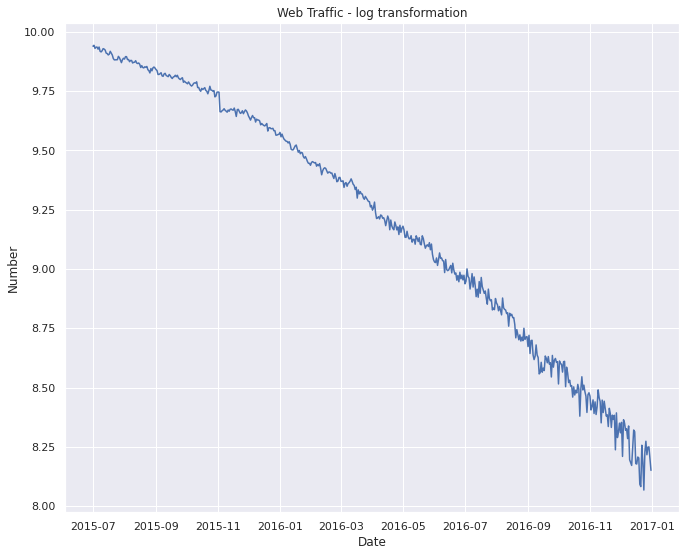

In [110]:
plt.title('Web Traffic - log transformation')
plt.xlabel('Date')
plt.ylabel('Number')
plt.plot(df_log)

In [114]:
test_stationarity(df_log['Visit'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                   3.616849
p-value                          1.000000
#Lags Used                      19.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64


From the test result as above, the data is still not stationary as the test statistic is larger than all critical values and the p-value is 1 which means the null hypothesis won't be rejected.

**Therefore, differecing method should be used before applying ARIMA model.**

Text(0.5, 1.0, 'Web Traffic (1st diff)')

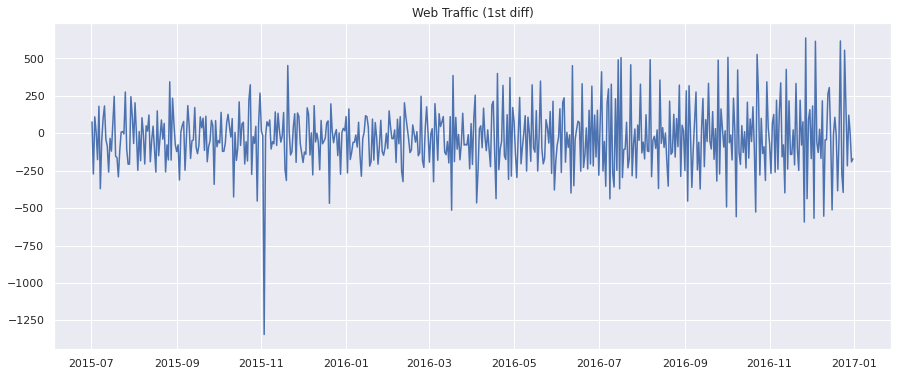

In [115]:
# 1st order diff
data_diff=df-df.shift()
data_diff.dropna(inplace=True)
plt.figure(figsize = (15,6))
plt.plot(data_diff)
plt.title("Web Traffic (1st diff)")

In [116]:
test_stationarity(data_diff['Visit'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.560172e+00
p-value                        3.024758e-11
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.442632e+00
Critical Value (5%)           -2.866957e+00
Critical Value (10%)          -2.569655e+00
dtype: float64


 **The plot of 1st diff shows that the data seems to be stationary as it remains the same mean value and the variance does not change very dramatical. Moreover, the test statistic is smaller than all the critical values so the data has been transfered to stationary data. Then we set d=1 for the ARIMA(p,d,q) process.**

**To ensure the transformed series is completely stationary, then checking its ACF and PACF in the following step.**

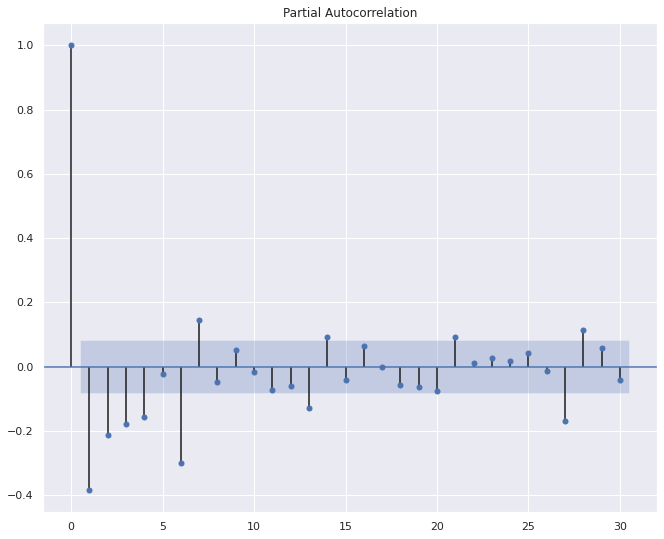

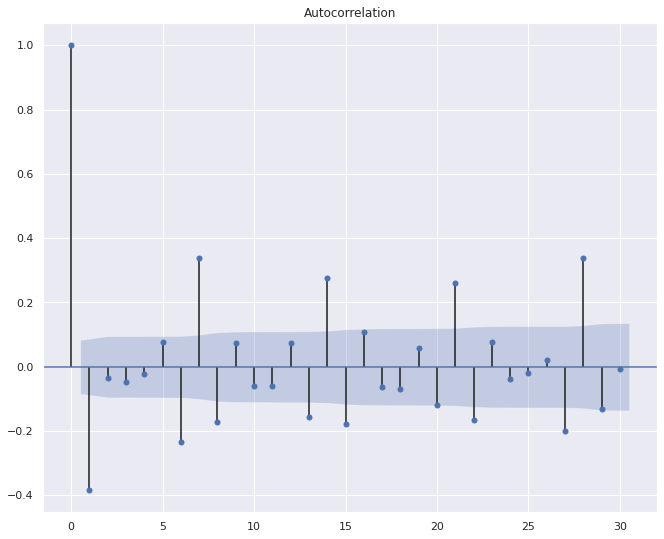

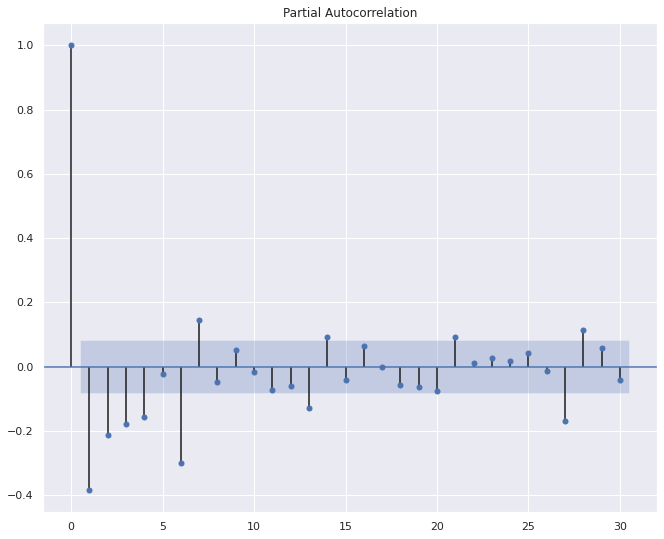

In [117]:
import statsmodels as sm
import statsmodels.api as smt
# Examine the ACF and PACF plot to obtain a suitable order for AR(p) and MA(q) process
smt.graphics.tsa.plot_acf(data_diff, lags=30, alpha = 0.05) 
smt.graphics.tsa.plot_pacf(data_diff, lags=30, alpha = 0.05)

Looking at the ACF and PACF plots(2nd and 3rd graphs), the cut off for ACF at lag 2 and at lag 2 for PACF therefore p=2 so the model is ARIMA(2,1,2). The idea on confirming the parameter is to choose the lag of time which is the starting point on concentrating the blue area.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'ARIMA(2,1,2) model fitted results')

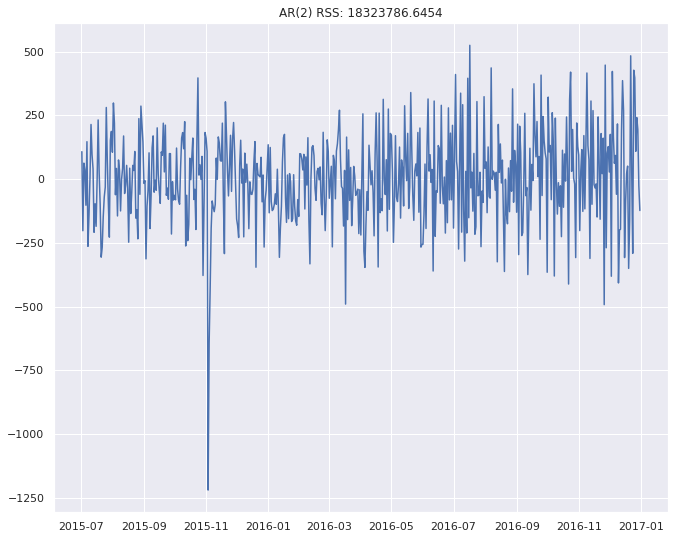

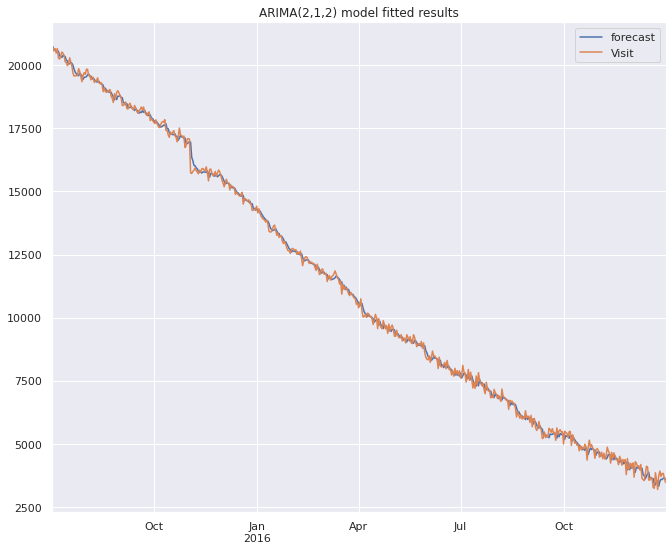

In [118]:
# plot the AR(2) of the differenced data = ARIMA(2,1,2)
from statsmodels.tsa.arima_model import ARIMA 
model = ARIMA(df, order=(2, 1, 2))
results_AR = model.fit(disp=-1) 
residuals = pd.DataFrame(results_AR.resid)
plt.figure() 
plt.plot(residuals) 
plt.title('AR(2) RSS: %.4f'% sum((results_AR.resid.values)**2))

# Get Fitted Series 
fitted =results_AR.predict(typ = 'levels', dynamic = False) #predicting the levels of the original time series

# Actual vs Fitted (fitting the data_log_diff)
results_AR.plot_predict(dynamic=False) #in-sample lagged values are used for prediction
plt.title("ARIMA(2,1,2) model fitted results")

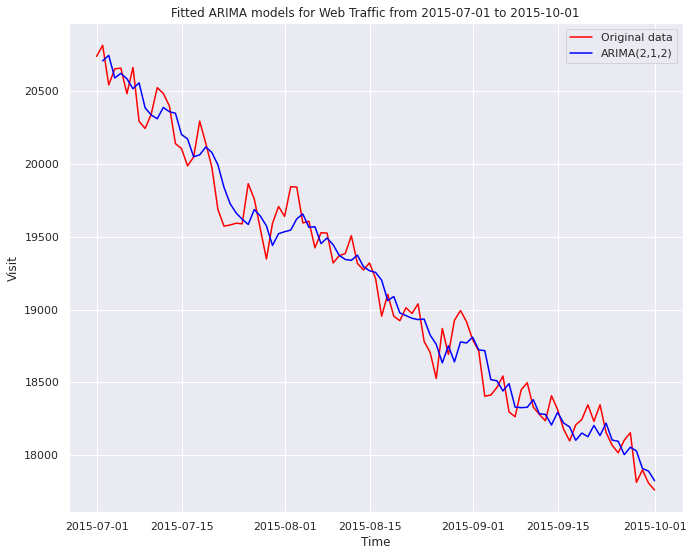

In [119]:
plt.plot(df['2015-07-01':"2015-10-01"],color='red', label = 'Original data')
plt.plot(fitted['2015-07-01':"2015-10-01"],color = 'blue', label='ARIMA(2,1,2)')
plt.title('Fitted ARIMA models for Web Traffic from 2015-07-01 to 2015-10-01')
plt.xlabel("Time")
plt.ylabel("Visit")
plt.legend()
plt.show()

Based on the plot as above, the ARIMA model is not able to capture all the changes of the no. of visits, however, the genearal trend is pretty similar with the original data.

In [120]:
# use the ARIMA model to predict
modelfit = ARIMA(data_arima['Visit'], order=(2, 1, 2))
modelfit= modelfit.fit(disp=-1) 
pred=modelfit.forecast(len(data_2016))

print('The MSE of ARIMA (2,1,2) is :',
      np.square(np.subtract(data_2016['Visit'],pred[0])).mean(), 'AIC:',modelfit.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The MSE of ARIMA (2,1,2) is : 1602848.923447867 AIC: 4785.279038821589


In [121]:
# summary of fit model
print(modelfit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Visit   No. Observations:                  366
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2386.640
Method:                       css-mle   S.D. of innovations            164.229
Date:                Mon, 04 Oct 2021   AIC                           4785.279
Time:                        22:50:38   BIC                           4808.695
Sample:                    07-02-2015   HQIC                          4794.584
                         - 07-01-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -35.7000      2.573    -13.873      0.000     -40.744     -30.656
ar.L1.D.Visit     0.0165      0.597      0.028      0.978      -1.153       1.186
ar.L2.D.Visit     0.1912      0.240     

The summary of the model shows that the AIC and BIC of the model is nearly 5000 which means the model is not able to fit the original data very well as lower AIC and BIC values indicate a better-fit model.

In [122]:
predfit=data_2016.copy()
predfit['Visit']=pred[0]

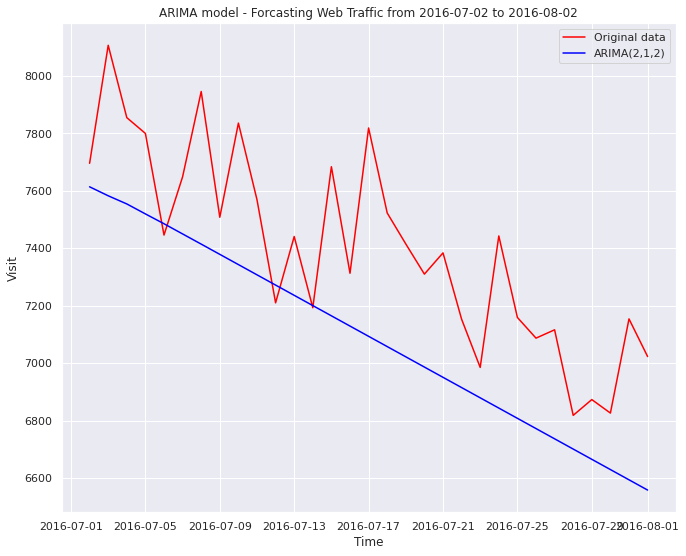

In [123]:
plt.plot(data_2016['2016-07-02':'2016-08-01'],color='red', label = 'Original data')
plt.plot(predfit['2016-07-02':'2016-08-01'],color = 'blue', label='ARIMA(2,1,2)')
plt.title('ARIMA model - Forcasting Web Traffic from 2016-07-02 to 2016-08-02')
plt.xlabel("Time")
plt.ylabel("Visit")
plt.legend()

**It is easy to see that the prediction outcome of the ARIMA is really poor as it cannot fit majority of the data points. Although the original data is on a decreasing trend, the total no. of visits are still fluctuated between this period. The predicted values that draw out by ARIMA model is on a linear trend and it is quit smooth which is not fitted with the actual situtation.**

**Therefore, the performance of ARIMA model on this prediction analysis is not well enough.**

## 4. Prediction Method - LSTM

Before running the simple LSTM model, the data set should be reshape as there is only one feature on this data set. 


In [133]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM

# reshape the data for model training
X=data_arima['Visit'][0:366]
Y=data_arima['Visit'][1:367]
X = np.array(X).reshape(366, 1, 1)

The network has a visible layer with 1 input, a hidden layer with 50 LSTM blocks or neurons(units=50), and an output layer that makes a single value prediction. The 'relu' activation function is used for the LSTM blocks. The network is trained for 100 epochs, a batch size of 5 and validation split is 0.2 is used for model setup.

These values of paramerters are setup randomly, if the prediction result is not good enough then the model will be setup with other values as parameters.

In [139]:
# model setup and training
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

# draw out the fitted value
fitted_value=model.fit(X, Y, epochs=100, validation_split=0.2, batch_size=5)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
59/59 [==============================] - 2s 6ms/step - loss: 222508096.0000 - val_loss: 62033884.0000
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 175447360.0000 - val_loss: 45785312.0000
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 121196752.0000 - val_loss: 28941762.0000
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 70004928.0000 - val_loss: 14675427.0000
Epoch 5/100
59/59 [==============================] 

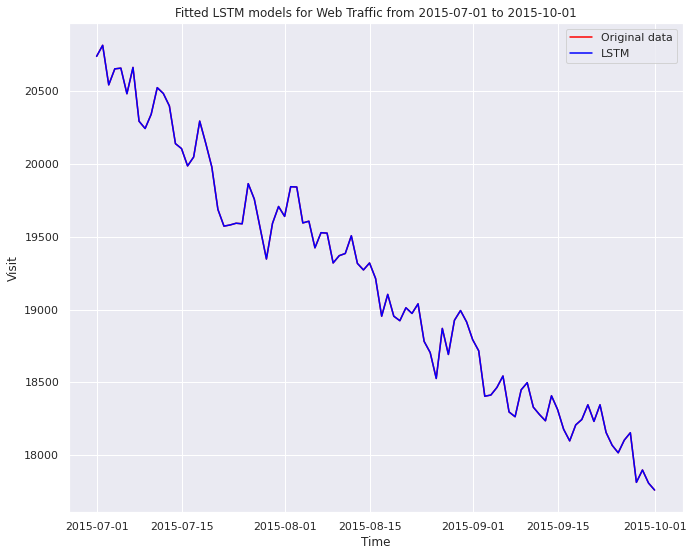

In [144]:
fitted_value= model.predict(X, verbose=0)
fitted_result=data_arima.copy()
fitted_result['Visit']=fitted_result
plt.plot(data_arima['2015-07-01':"2015-10-01"],color='red', label = 'Original data')
plt.plot(fitted_result['2015-07-01':"2015-10-01"],color = 'blue', label='LSTM')
plt.title('Fitted LSTM models for Web Traffic from 2015-07-01 to 2015-10-01')
plt.xlabel("Time")
plt.ylabel("Visit")
plt.legend()

**The graph as above shows that the LSTM model output fits with the original data really well and the fitted values which shows in blue is already overlapping the original data in red line.**

In [128]:
# draw out the prediction output 
test_input = data_2016['Visit']
test_input = np.array(test_input).reshape((183, 1, 1))
test_output = model.predict(test_input, verbose=0)
predfit=data_2016.copy()
predfit['Visit']=test_output

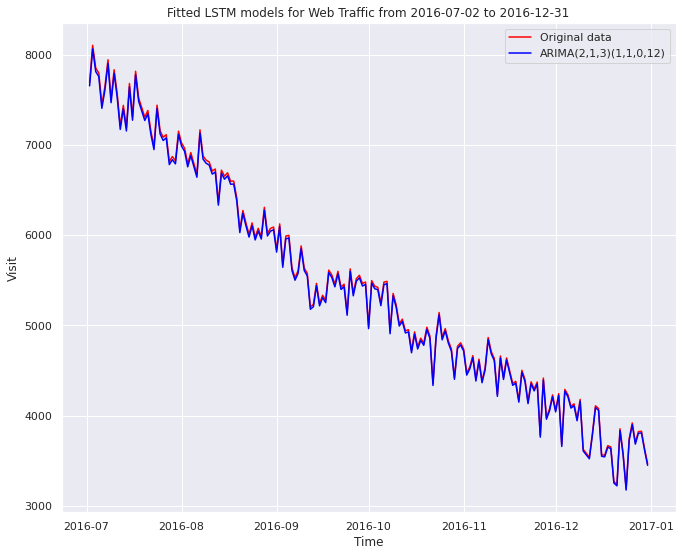

In [137]:
plt.plot(data_2016,color='red', label = 'Original data')
plt.plot(predfit,color = 'blue', label='ARIMA(2,1,3)(1,1,0,12)')
plt.title('Fitted LSTM models for Web Traffic from 2016-07-02 to 2016-12-31')
plt.xlabel("Time")
plt.ylabel("Visit")
plt.legend()

The final graph shows that the prediction outcome of LSTM is really good and able to capture all the fluctuated points in the original data. According to the graph, the predicted values in blue line is nearly to overlaping all the original data in red line.